In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Bits per Symbol
k = 4

# Number of symbols
L = 50

# Channel Use
n = 1

# Effective Throughput
#  (bits per symbol)*( number of symbols) / channel use
R = k / n

# Eb/N0 used for training
train_Eb_dB = 9

# Noise Standard Deviation
noise_sigma = np.sqrt(1 / (2 * R * 10 ** (train_Eb_dB / 10)))

# Number of messages used for training, each size = k*L
batch_size = 64
nb_train_word = batch_size*k*L

In [3]:
# Generate Binary Sequence
train_data = tf.random.uniform(shape=(nb_train_word, k*L), minval=0, maxval=2, dtype=tf.dtypes.int32)
train_data

<tf.Tensor: shape=(12800, 200), dtype=int32, numpy=
array([[0, 0, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1]], dtype=int32)>

In [4]:
# Reshaping into N x L x k (N: number of data messages, L: block length, k: bits/symbol)
train_data = tf.reshape(shape=(nb_train_word, L, k), tensor=train_data)
train_data.shape

TensorShape([12800, 50, 4])

In [5]:
def BitsToInt(bits, k):
    '''Function to transform a binary sequence into integers.'''
    '''@params:
        bits: binary sequence to be transformed
        k: bits per symbols
    '''
    a = 2**np.arange(k)[::-1]
    a = np.reshape(a, newshape=(k,1))
    return bits @ a

tmp = BitsToInt(train_data.numpy(),k)
print('Integers samples Shape:', tmp.shape)
one_hot_train = tf.keras.utils.to_categorical(y=tmp, num_classes=2 ** k)
print('One-Hot TRAINING Shape:', one_hot_train.shape)

Integers samples Shape: (12800, 50, 1)
One-Hot TRAINING Shape: (12800, 50, 16)


In [6]:
one_hot_labels = tf.identity(one_hot_train)
print('One-Hot LABELS Shape:', one_hot_labels.shape)

One-Hot LABELS Shape: (12800, 50, 16)


In [7]:
early_stopping_patience = 100

epochs = 50

optimizer = Adam(lr=0.001)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)


# Learning Rate Control
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001)

# Save the best results based on Training Set
modelcheckpoint = ModelCheckpoint(filepath='./' + 'model_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN_50_epochs' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', save_freq=1)


In [8]:
def normalization(x, ntype='Power'):
    '''Function to ensure hardware constraints.'''
    '''@params:
        x: input data
        ntype: type of constraint (avg or power)
    '''
    mean = tf.keras.backend.mean(x ** 2)
    if ntype == 'Power':
        # avg power constraints
        return x / tf.keras.backend.sqrt(2 * mean)  # 2 = I and Q channels
    elif ntype == 'Energy':
        # energy constraints
        return tf.keras.backend.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=1)


def AWGN_channel(x, sigma):
    '''Function to define AWGN channel layer.'''
    '''@params:
        x: input data
        sigma: noise standard deviation
    '''
    return x + tf.keras.backend.random_normal(tf.keras.backend.shape(x), mean=0.0, stddev=sigma)


#############
## Encoder ##
#############
model_input = Input(batch_shape=(batch_size, L, 2 ** k), name='input_bits')

e = Conv1D(filters=256, strides=1, kernel_size=1, name='encoder_1')(model_input)
e = BatchNormalization(name='encoder_1_batchnorm')(e)
e = Activation('elu', name='encoder_1_activation')(e)

e = Conv1D(filters=256, strides=1, kernel_size=1, name='encoder_2')(e)
e = BatchNormalization(name='encoder_2_batchnorm')(e)
e = Activation('elu', name='encoder_2_activation')(e)

e = Conv1D(filters=2 * n, strides=1, kernel_size=1, name='encoder_3')(e)  # 2 = I and Q channels
e = BatchNormalization(name='encoder_3_batchnorm')(e)
e = Activation('linear', name='encoder_3_activation')(e)

e = Lambda(normalization, name='normalization_layer')(e)

#############
## Channel ##
#############
y_h = Lambda(AWGN_channel, arguments={'sigma': noise_sigma}, name='channel_layer')(e)

#############
## Decoder ##
#############
d = Conv1D(filters=256, strides=1, kernel_size=1, name='decoder_1')(y_h)
d = BatchNormalization(name='decoder_1_batchnorm')(d)
d = Activation('elu', name='decoder_1_activation')(d)

d = Conv1D(filters=256, strides=1, kernel_size=1, name='decoder_2')(d)
d = BatchNormalization(name='decoder_2_batchnorm')(d)
d = Activation('elu', name='decoder_2_activation')(d)

# Output One hot vector and use Softmax to soft decoding
model_output = Conv1D(filters=2 ** k, strides=1, kernel_size=1, name='decoder_softmax', activation='softmax')(d)

# Build System Model
sys_model = Model(model_input, model_output)
encoder = Model(model_input, e)

sys_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      [(64, 50, 16)]            0         
_________________________________________________________________
encoder_1 (Conv1D)           (64, 50, 256)             4352      
_________________________________________________________________
encoder_1_batchnorm (BatchNo (64, 50, 256)             1024      
_________________________________________________________________
encoder_1_activation (Activa (64, 50, 256)             0         
_________________________________________________________________
encoder_2 (Conv1D)           (64, 50, 256)             65792     
_________________________________________________________________
encoder_2_batchnorm (BatchNo (64, 50, 256)             1024      
_________________________________________________________________
encoder_2_activation (Activa (64, 50, 256)             0     

In [9]:
# Compile Model
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# print('encoder output:', '\n', encoder.predict(vec_one_hot, batch_size=batch_size))

print('starting train the NN...')
start = time.clock()

# TRAINING
mod_history = sys_model.fit(one_hot_train, one_hot_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.3, callbacks=[modelcheckpoint,reduce_lr])

end = time.clock()

print('The NN has trained ' + str(end - start) + ' s')


starting train the NN...
Train on 8960 samples, validate on 3840 samples
Epoch 1/50

Epoch 00001: loss improved from inf to 0.27352, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
  64/8960 [..............................] - ETA: 6:41 - loss: 0.2735 - accuracy: 0.9374
Epoch 00001: loss improved from 0.27352 to 0.18202, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
 128/8960 [..............................] - ETA: 3:27 - loss: 0.2278 - accuracy: 0.9407
Epoch 00001: loss improved from 0.18202 to 0.16109, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
 192/8960 [..............................] - ETA: 2:24 - loss: 0.2055 - accuracy: 0.9443
Epoch 00001: loss improved from 0.16109 to 0.15300, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
 256/8960 [..............................] - ETA: 1:52 - loss: 0.1924 - accuracy: 0.9461
Epoch 00001: loss improved from 0.15300 to 0.13494, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
 320/8960 [>..........................

2752/8960 [========>.....................] - ETA: 17s - loss: 0.0723 - accuracy: 0.9783
Epoch 00001: loss did not improve from 0.02946
2816/8960 [========>.....................] - ETA: 16s - loss: 0.0713 - accuracy: 0.9787
Epoch 00001: loss did not improve from 0.02946
2880/8960 [========>.....................] - ETA: 16s - loss: 0.0704 - accuracy: 0.9790
Epoch 00001: loss improved from 0.02946 to 0.02709, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
2944/8960 [========>.....................] - ETA: 16s - loss: 0.0694 - accuracy: 0.9794
Epoch 00001: loss improved from 0.02709 to 0.02698, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
3008/8960 [=========>....................] - ETA: 15s - loss: 0.0685 - accuracy: 0.9797
Epoch 00001: loss improved from 0.02698 to 0.02594, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
3072/8960 [=========>....................] - ETA: 15s - loss: 0.0677 - accuracy: 0.9801
Epoch 00001: loss improved from 0.02594 to 0.02590, saving mode

6016/8960 [===================>..........] - ETA: 6s - loss: 0.0432 - accuracy: 0.9883
Epoch 00001: loss did not improve from 0.01242
6080/8960 [===================>..........] - ETA: 5s - loss: 0.0429 - accuracy: 0.9884
Epoch 00001: loss improved from 0.01242 to 0.01186, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
6144/8960 [===================>..........] - ETA: 5s - loss: 0.0426 - accuracy: 0.9885
Epoch 00001: loss improved from 0.01186 to 0.01166, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5
6208/8960 [===================>..........] - ETA: 5s - loss: 0.0422 - accuracy: 0.9886
Epoch 00001: loss did not improve from 0.01166
6272/8960 [====================>.........] - ETA: 5s - loss: 0.0419 - accuracy: 0.9887
Epoch 00001: loss did not improve from 0.01166
6336/8960 [====================>.........] - ETA: 5s - loss: 0.0416 - accuracy: 0.9888
Epoch 00001: loss did not improve from 0.01166
6400/8960 [====================>.........] - ETA: 5s - loss: 0.0413 - accuracy: 

 576/8960 [>.............................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00837
 640/8960 [=>............................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00837
 704/8960 [=>............................] - ETA: 11s - loss: 0.0099 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00837
 768/8960 [=>............................] - ETA: 11s - loss: 0.0099 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00837
 832/8960 [=>............................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9978
Epoch 00002: loss did not improve from 0.00837
 896/8960 [==>...........................] - ETA: 11s - loss: 0.0098 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00837
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00837
1024/8960 [==>...........................] - ETA: 10s -

4416/8960 [=============>................] - ETA: 6s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0091 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00751
4864/8960 [===============>..............] - ETA: 5s - loss: 0

8192/8960 [==========================>...] - ETA: 1s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00589
8640/8960 [===========================>..] - ETA: 0s - loss: 0

3008/8960 [=========>....................] - ETA: 10s - loss: 0.0069 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00551
3072/8960 [=========>....................] - ETA: 10s - loss: 0.0069 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00551
3136/8960 [=========>....................] - ETA: 10s - loss: 0.0069 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00551
3200/8960 [=========>....................] - ETA: 9s - loss: 0.0069 - accuracy: 0.9979 
Epoch 00003: loss did not improve from 0.00551
3264/8960 [=========>....................] - ETA: 9s - loss: 0.0069 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00551
3328/8960 [==========>...................] - ETA: 9s - loss: 0.0069 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00551
3392/8960 [==========>...................] - ETA: 9s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss improved from 0.00551 to 0.00538, saving model to ./model_4_50_1_9dB AWGN_50_epochs.h5


6912/8960 [======================>.......] - ETA: 3s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
6976/8960 [======================>.......] - ETA: 3s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
7040/8960 [======================>.......] - ETA: 3s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
7104/8960 [======================>.......] - ETA: 3s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
7168/8960 [=======================>......] - ETA: 3s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
7232/8960 [=======================>......] - ETA: 3s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0068 - accuracy: 0.9979
Epoch 00003: loss did not improve from 0.00457
7360/8960 [=======================>......] - ETA: 2s - loss: 0

1792/8960 [=====>........................] - ETA: 11s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
1856/8960 [=====>........................] - ETA: 11s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0066 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
2240/8960 [======>.......................] - ETA: 10s -

5696/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00457
6144/8960 [===================>..........] - ETA: 3s - loss: 0

 576/8960 [>.............................] - ETA: 11s - loss: 0.0061 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00415
 640/8960 [=>............................] - ETA: 11s - loss: 0.0062 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00415
 704/8960 [=>............................] - ETA: 11s - loss: 0.0062 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00415
 768/8960 [=>............................] - ETA: 11s - loss: 0.0062 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00415
 832/8960 [=>............................] - ETA: 11s - loss: 0.0062 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
 896/8960 [==>...........................] - ETA: 11s - loss: 0.0062 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
 960/8960 [==>...........................] - ETA: 11s - loss: 0.0062 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
1024/8960 [==>...........................] - ETA: 10s -

4480/8960 [==============>...............] - ETA: 6s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4608/8960 [==============>...............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4672/8960 [==============>...............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
4928/8960 [===============>..............] - ETA: 5s - loss: 0

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8704/8960 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8768/8960 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9979
Epoch 00005: loss did not improve from 0.00415
8832/8960 [============================>.] - ETA: 0s - loss: 0

3264/8960 [=========>....................] - ETA: 8s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0057 - accuracy: 0.9981
Epoch 00006: loss did not improve from 0.00415
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0057 - accuracy: 0.9981
Epoch 00006: loss did not improve from 0.00415
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0057 - accuracy: 0.9981
Epoch 00006: loss did not improve from 0.00415
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0057 - accuracy: 0.9981
Epoch 00006: loss did not improve from 0.00415
3712/8960 [===========>..................] - ETA: 7s - loss: 0

7168/8960 [=======================>......] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00415
7616/8960 [========================>.....] - ETA: 1s - loss: 0

2048/8960 [=====>........................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0054 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
2496/8960 [=======>......................] - ETA: 9s - loss: 0

5952/8960 [==================>...........] - ETA: 4s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0055 - accuracy: 0.9981
Epoch 00007: loss did not improve from 0.00415
6400/8960 [====================>.........] - ETA: 3s - loss: 0

 832/8960 [=>............................] - ETA: 11s - loss: 0.0054 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00415
 896/8960 [==>...........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00415
 960/8960 [==>...........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00415
1024/8960 [==>...........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00415
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00415
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00415
1216/8960 [===>..........................] - ETA: 10s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00415
1280/8960 [===>..........................] - ETA: 10s -

4672/8960 [==============>...............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
5120/8960 [================>.............] - ETA: 5s - loss: 0

8576/8960 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
8704/8960 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
8768/8960 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
8832/8960 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
8896/8960 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00410
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0056 - accuracy: 0.9980 - val_loss: 0.0054 - val_accuracy: 0.9981
Epoch 9/50

Epoch 00009: loss did not improve from 0.00410
 

3456/8960 [==========>...................] - ETA: 7s - loss: 0.0055 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0056 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0056 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0056 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0056 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0056 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0055 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
3904/8960 [============>.................] - ETA: 7s - loss: 0

7360/8960 [=======================>......] - ETA: 2s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00401
7808/8960 [=========================>....] - ETA: 1s - loss: 0

2240/8960 [======>.......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0056 - accuracy: 0.9980
Epoch 00010: loss did not improve from 0.00385
2688/8960 [========>.....................] - ETA: 9s - loss: 0

6144/8960 [===================>..........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0054 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00385
6592/8960 [=====================>........] - ETA: 3s - loss: 0

1024/8960 [==>...........................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1344/8960 [===>..........................] - ETA: 10s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1408/8960 [===>..........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
1472/8960 [===>..........................] - ETA: 10s -

4928/8960 [===============>..............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
5120/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00385
5184/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00385
5248/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
5312/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00385
5376/8960 [=================>............] - ETA: 5s - loss: 0

8832/8960 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00385
8896/8960 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00385
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0053 - accuracy: 0.9981 - val_loss: 0.0049 - val_accuracy: 0.9983
Epoch 12/50

Epoch 00012: loss did not improve from 0.00385
  64/8960 [..............................] - ETA: 14s - loss: 0.0041 - accuracy: 0.9984
Epoch 00012: loss did not improve from 0.00385
 128/8960 [..............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9984
Epoch 00012: loss did not improve from 0.00385
 192/8960 [..............................] - ETA: 13s - loss: 0.0048 - accuracy: 0.9983
Epoch 00012: loss did not improve from 0.00385
 256/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00

3712/8960 [===========>..................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00385
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00385
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00385
3904/8960 [============>.................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00385
3968/8960 [============>.................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00385
4032/8960 [============>.................] - ETA: 6s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00385
4096/8960 [============>.................] - ETA: 6s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00385
4160/8960 [============>.................] - ETA: 6s - loss: 0

7616/8960 [========================>.....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00370
8064/8960 [==========================>...] - ETA: 1s - loss: 0

2496/8960 [=======>......................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2816/8960 [========>.....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00370
2944/8960 [========>.....................] - ETA: 8s - loss: 0

6400/8960 [====================>.........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00013: loss did not improve from 0.00363
6848/8960 [=====================>........] - ETA: 3s - loss: 0

1280/8960 [===>..........................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1664/8960 [====>.........................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
1728/8960 [====>.........................] - ETA: 10s -

5184/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5248/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5312/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5376/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5440/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5504/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5568/8960 [=================>............] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00343
5632/8960 [=================>............] - ETA: 4s - loss: 0

 128/8960 [..............................] - ETA: 15s - loss: 0.0049 - accuracy: 0.9983
Epoch 00015: loss did not improve from 0.00343
 192/8960 [..............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00015: loss did not improve from 0.00343
 256/8960 [..............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00015: loss did not improve from 0.00343
 320/8960 [>.............................] - ETA: 14s - loss: 0.0049 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
 384/8960 [>.............................] - ETA: 14s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
 448/8960 [>.............................] - ETA: 14s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
 512/8960 [>.............................] - ETA: 14s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
 576/8960 [>.............................] - ETA: 14s -

4032/8960 [============>.................] - ETA: 7s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4096/8960 [============>.................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4160/8960 [============>.................] - ETA: 7s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4224/8960 [=============>................] - ETA: 7s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4288/8960 [=============>................] - ETA: 7s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4352/8960 [=============>................] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4416/8960 [=============>................] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
4480/8960 [==============>...............] - ETA: 6s - loss: 0

7936/8960 [=========================>....] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00343
8384/8960 [===========================>..] - ETA: 0s - loss: 0

2816/8960 [========>.....................] - ETA: 9s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00343
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00343
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
3264/8960 [=========>....................] - ETA: 8s - loss: 0

6720/8960 [=====================>........] - ETA: 3s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00343
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00343
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00343
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9981
Epoch 00016: loss did not improve from 0.00343
7168/8960 [=======================>......] - ETA: 2s - loss: 0

1600/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
1664/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00342
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00342
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
2048/8960 [=====>........................] - ETA: 10s -

5504/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5568/8960 [=================>............] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5632/8960 [=================>............] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00342
5952/8960 [==================>...........] - ETA: 4s - loss: 0

 384/8960 [>.............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
 448/8960 [>.............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
 512/8960 [>.............................] - ETA: 13s - loss: 0.0049 - accuracy: 0.9983
Epoch 00018: loss did not improve from 0.00342
 576/8960 [>.............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
 640/8960 [=>............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
 704/8960 [=>............................] - ETA: 12s - loss: 0.0052 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
 768/8960 [=>............................] - ETA: 12s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00342
 832/8960 [=>............................] - ETA: 12s -

4288/8960 [=============>................] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4352/8960 [=============>................] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4416/8960 [=============>................] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
4736/8960 [==============>...............] - ETA: 6s - loss: 0

8192/8960 [==========================>...] - ETA: 1s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00342
8640/8960 [===========================>..] - ETA: 0s - loss: 0

3072/8960 [=========>....................] - ETA: 8s - loss: 0.0049 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
3520/8960 [==========>...................] - ETA: 8s - loss: 0

6976/8960 [======================>.......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00019: loss did not improve from 0.00342
7424/8960 [=======================>......] - ETA: 2s - loss: 0

1792/8960 [=====>........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
1856/8960 [=====>........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00307
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00307
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00307
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00307
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00307
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00307
2240/8960 [======>.......................] - ETA: 10s -

5696/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00307
6144/8960 [===================>..........] - ETA: 4s - loss: 0

 576/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
 640/8960 [=>............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
 704/8960 [=>............................] - ETA: 13s - loss: 0.0048 - accuracy: 0.9982
Epoch 00021: loss did not improve from 0.00307
 768/8960 [=>............................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9982
Epoch 00021: loss did not improve from 0.00307
 832/8960 [=>............................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00021: loss did not improve from 0.00307
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00021: loss did not improve from 0.00307
1024/8960 [==>...........................] - ETA: 12s -

4480/8960 [==============>...............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
4928/8960 [===============>..............] - ETA: 5s - loss: 0

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8704/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8768/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00307
8832/8960 [============================>.] - ETA: 0s - loss: 0

3264/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3584/8960 [===========>..................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00022: loss did not improve from 0.00307
3712/8960 [===========>..................] - ETA: 7s - loss: 0

7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00307
7616/8960 [========================>.....] - ETA: 1s - loss: 0

2048/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
2240/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983 
Epoch 00023: loss did not improve from 0.00307
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
2496/8960 [=======>......................] - ETA: 9s - lo

5952/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00307
6400/8960 [====================>.........] - ETA: 3s - loss: 0

 832/8960 [=>............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
1024/8960 [==>...........................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
1088/8960 [==>...........................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
1152/8960 [==>...........................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00024: loss did not improve from 0.00307
1280/8960 [===>..........................] - ETA: 11s -

4736/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00307
5184/8960 [================>.............] - ETA: 5s - loss: 0

8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
8704/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0043 - val_accuracy: 0.9985
Epoch 25/50

Epoch 00025: loss did not improve from 0.00290
  64/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9980
Epoch 00025: loss did not improve from 0.00290

3520/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00025: loss did not improve from 0.00290
3584/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3968/8960 [============>.................] - ETA: 7s - loss: 0

7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7872/8960 [=========================>....] - ETA: 1s - loss: 0

2304/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2368/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2432/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2496/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2560/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2624/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2688/8960 [========>.....................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00026: loss did not improve from 0.00290
2752/8960 [========>.....................] - ETA: 9s - 

6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6400/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6464/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6656/8960 [=====================>........] - ETA: 3s - loss: 0

1088/8960 [==>...........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00027: loss did not improve from 0.00290
1536/8960 [====>.........................] - ETA: 11s -

4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5312/8960 [================>.............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5440/8960 [=================>............] - ETA: 5s - loss: 0

8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9984
Epoch 28/50

Epoch 00028: loss did not improve from 0.00290
  64/8960 [..............................] - ETA: 14s - loss: 0.0041 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 128/8960 [..............................] - ETA: 14s - loss: 0.0043 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 192/8960 [..............................] - ETA: 13s - loss: 0.0042 - accuracy: 0.9985
Epoch 00028: loss did not improve from 0.00290
 256/8960 [..............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 320/8960 [>.............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9985
Epoch 00028: loss did not improve from 0.0

3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
3904/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
4032/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
4096/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4160/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4224/8960 [=============>................] - ETA: 7s - loss: 0

7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8128/8960 [==========================>...] - ETA: 1s - loss: 0

2560/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
2880/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
2944/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00029: loss did not improve from 0.00290
3008/8960 [=========>....................] - ETA: 8s - loss: 0

6464/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6912/8960 [======================>.......] - ETA: 3s - loss: 0

1344/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1664/8960 [====>.........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1728/8960 [====>.........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9985
Epoch 00030: loss did not improve from 0.00290
1792/8960 [=====>........................] - ETA: 10s -

5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5312/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5632/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5696/8960 [==================>...........] - ETA: 4s - loss: 0

 192/8960 [..............................] - ETA: 14s - loss: 0.0041 - accuracy: 0.9985
Epoch 00031: loss did not improve from 0.00290
 256/8960 [..............................] - ETA: 13s - loss: 0.0042 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
 320/8960 [>.............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
 384/8960 [>.............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
 448/8960 [>.............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
 512/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
 576/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
 640/8960 [=>............................] - ETA: 13s -

4096/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4160/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4224/8960 [=============>................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4288/8960 [=============>................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4352/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4416/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
4544/8960 [==============>...............] - ETA: 6s - loss: 0

8000/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00031: loss did not improve from 0.00290
8448/8960 [===========================>..] - ETA: 0s - loss: 0

2880/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
3328/8960 [==========>...................] - ETA: 8s - loss: 0

6784/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00032: loss did not improve from 0.00290
7232/8960 [=======================>......] - ETA: 2s - loss: 0

1664/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2112/8960 [======>.......................] - ETA: 10s -

5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
5632/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00033: loss did not improve from 0.00290
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00033: loss did not improve from 0.00290
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00033: loss did not improve from 0.00290
6016/8960 [===================>..........] - ETA: 4s - loss: 0

 448/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 512/8960 [>.............................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
 576/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 640/8960 [=>............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 704/8960 [=>............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 768/8960 [=>............................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 832/8960 [=>............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 896/8960 [==>...........................] - ETA: 12s -

4352/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4416/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
4800/8960 [===============>..............] - ETA: 6s - loss: 0

8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00034: loss did not improve from 0.00290
8704/8960 [============================>.] - ETA: 0s - loss: 0

3136/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00035: loss did not improve from 0.00290
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00035: loss did not improve from 0.00290
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3584/8960 [===========>..................] - ETA: 8s - loss: 0

7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00282
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00035: loss did not improve from 0.00282
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00282
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00282
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00282
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00282
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00035: loss did not improve from 0.00282
7488/8960 [========================>.....] - ETA: 2s - loss: 0

1920/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
2240/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
2304/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00282
2368/8960 [======>.......................] - ETA: 10s -

5824/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00282
6272/8960 [====================>.........] - ETA: 4s - loss: 0

 704/8960 [=>............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
 768/8960 [=>............................] - ETA: 12s - loss: 0.0043 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
 832/8960 [=>............................] - ETA: 12s - loss: 0.0043 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
1024/8960 [==>...........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
1152/8960 [==>...........................] - ETA: 11s -

4608/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
4672/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
4736/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
4992/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
5056/8960 [===============>..............] - ETA: 6s - loss: 0

8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00282
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00037: loss did not improve from 0.00282
8960/8960 [==============================] - 16s 2ms/sample - 

3392/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3584/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3648/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00242
3840/8960 [===========>..................] - ETA: 7s - loss: 0

7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7616/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00242
7744/8960 [========================>.....] - ETA: 1s - loss: 0

2176/8960 [======>.......................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2240/8960 [======>.......................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2304/8960 [======>.......................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2368/8960 [======>.......................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2432/8960 [=======>......................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2496/8960 [=======>......................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2560/8960 [=======>......................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
2624/8960 [=======>......................] - ETA: 11s -

6080/8960 [===================>..........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6144/8960 [===================>..........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6208/8960 [===================>..........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6400/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6464/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00242
6528/8960 [====================>.........] - ETA: 4s - loss: 0

 960/8960 [==>...........................] - ETA: 15s - loss: 0.0045 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
1024/8960 [==>...........................] - ETA: 15s - loss: 0.0045 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
1088/8960 [==>...........................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
1152/8960 [==>...........................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
1216/8960 [===>..........................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
1280/8960 [===>..........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
1344/8960 [===>..........................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
1408/8960 [===>..........................] - ETA: 13s -

4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
4992/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
5056/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00242
5312/8960 [================>.............] - ETA: 5s - loss: 0

8768/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
8832/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
8896/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00040: loss did not improve from 0.00242
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0045 - val_accuracy: 0.9984
Epoch 41/50

Epoch 00041: loss did not improve from 0.00242
  64/8960 [..............................] - ETA: 13s - loss: 0.0055 - accuracy: 0.9978
Epoch 00041: loss did not improve from 0.00242
 128/8960 [..............................] - ETA: 13s - loss: 0.0052 - accuracy: 0.9979
Epoch 00041: loss did not improve from 0.00242
 192/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9980
Epoch 00041: loss did not improve from 0.002

3648/8960 [===========>..................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00242
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00242
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00242
3904/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
3968/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
4032/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
4096/8960 [============>.................] - ETA: 7s - loss: 0

7552/8960 [========================>.....] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
7616/8960 [========================>.....] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00242
8000/8960 [=========================>....] - ETA: 1s - loss: 0

2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00242
2880/8960 [========>.....................] - ETA: 9s - loss: 0

6336/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00242
6784/8960 [=====================>........] - ETA: 3s - loss: 0

1216/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9982
Epoch 00043: loss did not improve from 0.00242
1664/8960 [====>.........................] - ETA: 10s -

5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5312/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00043: loss did not improve from 0.00242
5568/8960 [=================>............] - ETA: 5s - loss: 0

  64/8960 [..............................] - ETA: 15s - loss: 0.0054 - accuracy: 0.9980
Epoch 00044: loss did not improve from 0.00242
 128/8960 [..............................] - ETA: 15s - loss: 0.0050 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
 192/8960 [..............................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
 256/8960 [..............................] - ETA: 15s - loss: 0.0048 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
 320/8960 [>.............................] - ETA: 15s - loss: 0.0048 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
 384/8960 [>.............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
 448/8960 [>.............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
 512/8960 [>.............................] - ETA: 15s -

3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
4096/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
4160/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
4224/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
4288/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
4352/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00242
4416/8960 [=============>................] - ETA: 7s - loss: 0

7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00044: loss did not improve from 0.00242
8320/8960 [==========================>...] - ETA: 1s - loss: 0

2752/8960 [========>.....................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
2816/8960 [========>.....................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
2880/8960 [========>.....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
2944/8960 [========>.....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
3008/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
3072/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
3136/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
3200/8960 [=========>....................] - ETA: 10s -

6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
6976/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
7040/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00242
7104/8960 [======================>.......] - ETA: 3s - loss: 0

1536/8960 [====>.........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1664/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
1984/8960 [=====>........................] - ETA: 10s -

5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5632/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00046: loss did not improve from 0.00242
5888/8960 [==================>...........] - ETA: 4s - loss: 0

 320/8960 [>.............................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
 384/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9985
Epoch 00047: loss did not improve from 0.00242
 448/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
 512/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
 576/8960 [>.............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
 640/8960 [=>............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
 704/8960 [=>............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
 768/8960 [=>............................] - ETA: 12s -

4224/8960 [=============>................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4288/8960 [=============>................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4352/8960 [=============>................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4416/8960 [=============>................] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
4672/8960 [==============>...............] - ETA: 6s - loss: 0

8128/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00242
8576/8960 [===========================>..] - ETA: 0s - loss: 0

3008/8960 [=========>....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
3456/8960 [==========>...................] - ETA: 8s - loss: 0

6912/8960 [======================>.......] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
6976/8960 [======================>.......] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00242
7360/8960 [=======================>......] - ETA: 2s - loss: 0

1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
2240/8960 [======>.......................] - ETA: 10s -

5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00242
6144/8960 [===================>..........] - ETA: 4s - loss: 0

 576/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
 640/8960 [=>............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
 704/8960 [=>............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
 768/8960 [=>............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
 832/8960 [=>............................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00050: loss did not improve from 0.00242
1024/8960 [==>...........................] - ETA: 12s -

4480/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
4928/8960 [===============>..............] - ETA: 6s - loss: 0

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8704/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8768/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00242
8832/8960 [============================>.] - ETA: 0s - loss: 0

loss: [0.0326144026791943, 0.008397786595326449, 0.006733368400351277, 0.0063184933504089715, 0.00610919678251126, 0.005855004622467927, 0.005504508509433695, 0.005621830247608679, 0.005652473614151989, 0.005333064165565052, 0.005252595398841159, 0.005216126524776752, 0.005247633071017585, 0.005093252096724297, 0.005025176639069936, 0.005129245894828013, 0.0050640960889203205, 0.00506401293345594, 0.005022738353415791, 0.004514105064195714, 0.004712683552809592, 0.004589466098695994, 0.0046164041867346635, 0.004549238321903561, 0.004630695080517658, 0.0045957768668553655, 0.0045501409397859655, 0.0046372714469076265, 0.004520676539479089, 0.004651740808705134, 0.004541962450769331, 0.004655025269104434, 0.004568268563265779, 0.004641533820956413, 0.0045594804654163976, 0.004529929816323732, 0.004587724515503006, 0.004554628863531564, 0.0045801132385219845, 0.004536448512226343, 0.004532151679242296, 0.004570193952947323, 0.004605321296756821, 0.004620070178394339, 0.004574335303290614,

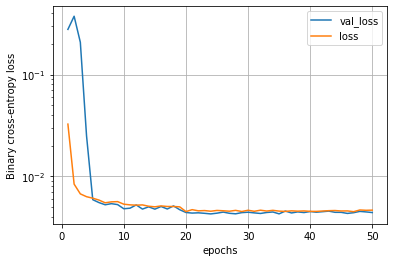

In [10]:
# Plot the Training Loss and Validation Loss
hist_dict = mod_history.history

val_loss = hist_dict['val_loss']
loss = hist_dict['loss']
# acc = hist_dict['acc']
# val_acc = hist_dict['val_acc']
print('loss:',loss)
print('val_loss:',val_loss)

epoch = np.arange(1, epochs + 1)

plt.semilogy(epoch,val_loss,label='val_loss')
plt.semilogy(epoch, loss, label='loss')

plt.legend(loc=0)
plt.grid('true')
plt.xlabel('epochs')
plt.ylabel('Binary cross-entropy loss')

plt.show()